# Bayesian Temporal Matrix Factorization

**Published**: October 8, 2019

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**transdim**](https://github.com/xinychen/transdim/blob/master/imputer/BTMF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Matrix Factorization (BTMF) model on some real-world data sets. To overcome the problem of missing values within multivariate time series data, this model takes into account both low-rank structure and time series autoregression. For an in-depth discussion of BTMF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

## Abstract

Large-scale and multidimensional spatiotemporal data sets are becoming ubiquitous in many real-world applications such as monitoring traffic and air quality. Making predictions on these time series has become a critical challenge due to not only the large-scale and high-dimensional nature but also the considerable amount of missing data. In this work, we propose a Bayesian Temporal Matrix Factorization (BTMF) model for modeling multidimensional time series - and in particular spatiotemporal data - in the presence of missing data. By integrating low-rank matrix factorization and vector autoregressive (VAR) process into a single probabilistic graphical model, our model can effectively perform predictions without imputing those missing values. We develop efficient Gibbs sampling algorithms for model inference and test the proposed BTMF on several real-world spatiotemporal data sets for both missing data imputation and short-term rolling prediction tasks. This post is mainly about BTMF and its **`Python`** implementation with an application of spatiotemporal data imputation.

## Motivation



## Problem Description

We assume a spatiotemporal setting for multidimensional time series data throughout this work. In general, modern spatiotemporal data sets collected from sensor networks can be organized as matrix time series. For example, we can denote by matrix $Y\in\mathbb{R}^{N\times T}$ a multivariate time series collected from $N$ locations/sensors on $T$ time points, with each row $$\boldsymbol{y}_{i}=\left(y_{i,1},y_{i,2},...,y_{i,t-1},y_{i,t},y_{i,t+1},...,y_{i,T}\right)$$
corresponding to the time series collected at location $i$.

As mentioned, making accurate predictions on incomplete time series is very challenging, while missing data problem is almost inevitable in real-world applications. Figure 1 illustrates the prediction problem for incomplete time series data. Here we use $(i,t)\in\Omega$ to index the observed entries in matrix $Y$.

<img src="../images/graphical_matrix_time_series.png" alt="drawing" width="500"/>

> **Figure 1**: Illustration of multivariate time series and the prediction problem in the presence of missing values (green: observed data; white: missing data; red: prediction).


## Model Description

Given a partially observed spatiotemporal matrix $Y\in\mathbb{R}^{N \times T}$, one can factorize it into a spatial factor matrix $W\in\mathbb{R}^{R \times N}$ and a temporal factor matrix $X\in\mathbb{R}^{R \times T}$ following general matrix factorization model:
\begin{equation}
Y\approx W^{\top}X,
\label{btmf_equation1}
\end{equation}
and element-wise, we have
\begin{equation}
y_{it}\approx \boldsymbol{w}_{i}^\top\boldsymbol{x}_{t}, \quad \forall (i,t),
\label{btmf_equation2}
\end{equation}
where vectors $\boldsymbol{w}_{i}$ and $\boldsymbol{x}_{t}$ refer to the $i$-th column of $W$ and the $t$-th column of $X$, respectively.

The standard matrix factorization model is a good approach to deal with the missing data problem; however, it cannot capture the dependencies among different columns in $X$, which are critical in modeling time series data. To better characterize the temporal dependencies and impose temporal smoothness, a novel AR regularizer is introduced on $X$ in TRMF (i.e., Temporal Regularizer Matrix Factorization proposed by [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf)):
\begin{equation} \label{equ:VAR}
\begin{aligned}
    \boldsymbol{x}_{t+1}&=\sum\nolimits_{k=1}^{d}A_{k}\boldsymbol{x}_{t+1-h_k}+\boldsymbol{\epsilon}_t, \\
    &=A^\top \boldsymbol{v}_{t+1}+\boldsymbol{\epsilon}_{t}, \\
\end{aligned}
\end{equation}
where $\mathcal{L}=\left\{h_1,\ldots,h_k,\ldots,h_d\right\}$ is a lag set ($d$ is the order of this AR model), each $A_k$ ($k\in\left\{1,...,d\right\}$) is a $R\times R$ coefficient matrix, and $\boldsymbol{\epsilon}_t$ is a zero mean Gaussian noise vector. For brevity, matrix $A\in \mathbb{R}^{(R d) \times R}$ and vector $\boldsymbol{v}_{t+1}\in \mathbb{R}^{(R d) \times 1}$ are defined as
\begin{equation*}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} ,\quad \boldsymbol{v}_{t+1}=\left[\begin{array}{c}{\boldsymbol{x}_{t+1-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t+1-h_d}}\end{array}\right] .
\end{equation*}

<img src="../images/rolling_prediction.png" alt="drawing" width="400"/>

> **Figure 2**: A graphical illustration of the rolling prediction scheme using BTMF (with VAR process) (green: observed data; white: missing data; red: prediction).

In [Yu et al., 2016](https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf), to avoid overfitting and reduce the number of parameters, the coefficient matrix in TRMF is further assumed to be a diagonal $A_k=\text{diag}(\boldsymbol{\theta}_{k})$. Therefore, they have
\begin{equation} \label{equ:AR}
\boldsymbol{x}_{t+1}=\boldsymbol{\theta}_{1}\circledast\boldsymbol{x}_{t+1-h_1}+\cdots+\boldsymbol{\theta}_{d}\circledast\boldsymbol{x}_{t+1-h_d}+\boldsymbol{\epsilon}_t,
\end{equation}
where the symbol $\circledast$ denotes the element-wise Hadamard product. However, unlike Equation (4), a vector autoregressive (VAR) model in Equation (3) is actually more powerful for capturing multivariate time series patterns. 

<img src="../images/rolling_prediction_strategy.png" alt="drawing" width="400"/>

> **Figure 3**: A graphical illustration of the rolling prediction scheme using BTMF (with AR process) (green: observed data; white: missing data; red: prediction).

In the following, we first introduce a Bayesian temporal matrix factorization model with an autoregressive model given in Equation (4), and then discuss another model with a vector autoregressive (VAR) model shown in Equation (3).



## Bayesian Temporal Matrix Factorization with Vector Autoregressive Model

### 1 Model Specification

Following the general Bayesian probabilistic matrix factorization models (e.g., BPMF proposed by [Salakhutdinov & Mnih, 2008](https://www.cs.toronto.edu/~amnih/papers/bpmf.pdf)), we assume that each observed entry in $Y$ follows a Gaussian distribution with precision $\tau$:
\begin{equation}
y_{i,t}\sim\mathcal{N}\left(\boldsymbol{w}_i^\top\boldsymbol{x}_t,\tau^{-1}\right),\quad \left(i,t\right)\in\Omega.
\label{btmf_equation3}
\end{equation}

On the spatial dimension, we use a simple Gaussian factor matrix without imposing any dependencies explicitly:
\begin{equation}
\boldsymbol{w}_i\sim\mathcal{N}\left(\boldsymbol{\mu}_{w},\Lambda_w^{-1}\right),
\end{equation}
and we place a conjugate Gaussian-Wishart prior on the mean vector and the precision matrix:
\begin{equation}
\boldsymbol{\mu}_w | \Lambda_w \sim\mathcal{N}\left(\boldsymbol{\mu}_0,(\beta_0\Lambda_w)^{-1}\right),\Lambda_w\sim\mathcal{W}\left(W_0,\nu_0\right),
\end{equation}
where $\boldsymbol{\mu}_0\in \mathbb{R}^{R}$ is a mean vector, $\mathcal{W}\left(W_0,\nu_0\right)$ is a Wishart distribution with a $R\times R$ scale matrix $W_0$ and $\nu_0$ degrees of freedom.

In modeling the temporal factor matrix $X$, we re-write the VAR process as:
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}
\mathcal{N}\left(\boldsymbol{0},I_R\right),&\text{if $t\in\left\{1,2,...,h_d\right\}$}, \\
\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),&\text{otherwise},\\
\end{cases}\\
\end{aligned}
\label{btmf_equation5}
\end{equation}

Since the mean vector is defined by VAR, we need to place the conjugate matrix normal inverse Wishart (MNIW) prior on the coefficient matrix $A$ and the covariance matrix $\Sigma$ as follows,
\begin{equation}
\begin{aligned}
A\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right),\quad
\Sigma \sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where the probability density function for the $Rd$-by-$R$ random matrix $A$ has the form:
\begin{equation}
\begin{aligned}
&p\left(A\mid M_0,\Psi_0,\Sigma\right) \\
=&\left(2\pi\right)^{-R^2d/2}\left|\Psi_0\right|^{-R/2}\left|\Sigma\right|^{-Rd/2} \\
&\times \exp\left(-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(A-M_0\right)^{\top}\Psi_{0}^{-1}\left(A-M_0\right)\right]\right), \\
\end{aligned}
\label{mnpdf}
\end{equation}
where $\Psi_0\in\mathbb{R}^{(Rd)\times (Rd)}$ and $\Sigma\in\mathbb{R}^{R\times R}$ are played as covariance matrices.

For the only remaining parameter $\tau$, we place a Gamma prior  $\tau\sim\text{Gamma}\left(\alpha,\beta\right)$ where $\alpha$ and $\beta$ are the shape and rate parameters, respectively. 

The above specifies the full generative process of BTMF, and we could also see the Bayesian graphical model shown in Figure 4. Several parameters are introduced to define the prior distributions for hyperparameters, including $\boldsymbol{\mu}_{0}$, $W_0$, $\nu_0$, $\beta_0$, $\alpha$, $\beta$, $M_0$, $\Psi_0$, and $S_0$. These parameters need to provided in advance when training the model. However, it should be noted that the specification of these parameters has little impact on the final results, as the training data will play a much more important role in defining the posteriors of the hyperparameters.

<img src="../images/btmf_net.png" alt="drawing" width="450"/>

> **Figure 4**: An overview graphical model of BTMF (time lag set: $\left\{1,2,...,d\right\}$). The shaded nodes ($y_{i,t}$) are the observed data in $\Omega$.


### 2 Model Inference

Given the complex structure of BTMF, it is intractable to write down the posterior distribution. Here we rely on the MCMC technique for Bayesian learning. In detail, we introduce a Gibbs sampling algorithm by deriving the full conditional distributions for all parameters and hyperparameters. Thanks to the use of conjugate priors in Figure 4, we can actually write down all the conditional distributions analytically. Below we summarize the Gibbs sampling procedure.  


#### 1) Sampling Factor Matrix $W$ and Its Hyperparameters



> For programming convenience, we use $W\in\mathbb{R}^{N\times R}$ to replace $W\in\mathbb{R}^{R\times N}$.

In [1]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart

def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

def cov_mat(mat):
    new_mat = mat - np.mean(mat, axis = 0)
    return np.einsum('ti, tj -> ij', new_mat, new_mat)

def sample_factor_w(sparse_mat, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    binary_mat = sparse_mat.copy()
    binary_mat[binary_mat != 0] = 1
    W_bar = np.mean(W, axis = 0)
    var_mu_hyper = (dim1 * W_bar) / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W) + dim1 * beta0 / (dim1 + beta0) * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart(df = dim1 + rank, scale = var_W_hyper, seed = None).rvs()
    var_mu_hyper = mvnrnd(var_mu_hyper, inv((dim1 + beta0) * var_Lambda_hyper))
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        binary_mat = sparse_mat.copy()
        binary_mat[binary_mat != 0] = 1
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * (var2 @ binary_mat.T).reshape([rank, rank, dim1]) + np.dstack([var_Lambda_hyper] * dim1)
        var4 = tau * var1 @ sparse_mat.T + np.dstack([var_Lambda_hyper @ var_mu_hyper] * dim1)[0, :, :]
        for i in range(dim1):
            inv_var_Lambda = inv(var3[:, :, i])
            W[i, :] = mvnrnd(inv_var_Lambda @ var4[:, i], inv_var_Lambda)
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            inv_var_Lambda = inv(tau * Xt.T @ Xt + var_Lambda_hyper)
            W[i, :] = mvnrnd(inv_var_Lambda @ var_mu, inv_var_Lambda)
    
    return W

#### 2) Sampling VAR Coefficients $A$ and Its Hyperparameters

**Foundations of VAR**

Vector autoregression (VAR) is a multivariate extension of autoregression (AR). Formally, VAR for $R$-dimensional vectors $\boldsymbol{x}_{t}$ can be written as follows,
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&=A_{1} \boldsymbol{x}_{t-h_1}+\cdots+A_{d} \boldsymbol{x}_{t-h_d}+\boldsymbol{\epsilon}_{t}, \\
&= A^\top \boldsymbol{v}_{t}+\boldsymbol{\epsilon}_{t},~t=h_d+1, \ldots, T, \\
\end{aligned}
\end{equation}
where
\begin{equation}
A=\left[A_{1}, \ldots, A_{d}\right]^{\top} \in \mathbb{R}^{(R d) \times R},\quad \boldsymbol{v}_{t}=\left[\begin{array}{c}{\boldsymbol{x}_{t-h_1}} \\ {\vdots} \\ {\boldsymbol{x}_{t-h_d}}\end{array}\right] \in \mathbb{R}^{(R d) \times 1}.
\end{equation}

In the following, if we define
\begin{equation}
Z=\left[\begin{array}{c}{\boldsymbol{x}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times R},\quad Q=\left[\begin{array}{c}{\boldsymbol{v}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{v}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times(R d)},
\end{equation}
then, we could write the above mentioned VAR as
\begin{equation}
\underbrace{Z}_{(T-h_d)\times R}\approx \underbrace{Q}_{(T-h_d)\times (Rd)}\times \underbrace{A}_{(Rd)\times R}.
\end{equation}

> To include temporal factors $\boldsymbol{x}_{t},t=1,...,h_d$, we also define $$Z_0=\left[\begin{array}{c}{\boldsymbol{x}_{1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{h_d}^{\top}}\end{array}\right] \in \mathbb{R}^{h_d \times R}.$$



**Build a Bayesian VAR on temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(A^\top \boldsymbol{v}_{t},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I_R\right),~\text{otherwise}}.\end{cases}\\
A&\sim\mathcal{MN}_{(Rd)\times R}\left(M_0,\Psi_0,\Sigma\right), \\
\Sigma &\sim\mathcal{IW}\left(S_0,\nu_0\right), \\
\end{aligned}
\end{equation}
where
\begin{equation}
\begin{aligned}
&\mathcal{M N}_{(R d) \times R}\left(A | M_{0}, \Psi_{0}, \Sigma\right)\\
\propto|&\Sigma|^{-R d / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left[\Sigma^{-1}\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)\right]\right), \\
\end{aligned}
\end{equation}
and
\begin{equation}
\mathcal{I} \mathcal{W}\left(\Sigma | S_{0}, \nu_{0}\right) \propto|\Sigma|^{-\left(\nu_{0}+R+1\right) / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left(\Sigma^{-1}S_{0}\right)\right).
\end{equation}


**Likelihood from temporal factors $\boldsymbol{x}_{t}$**
\begin{equation}
\begin{aligned}
&\mathcal{L}\left(X\mid A,\Sigma\right) \\
\propto &\prod_{t=1}^{h_d}p\left(\boldsymbol{x}_{t}\mid \Sigma\right)\times \prod_{t=h_d+1}^{T}p\left(\boldsymbol{x}_{t}\mid A,\Sigma\right) \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\sum_{t=h_d+1}^{T}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)^\top\Sigma^{-1}\left(\boldsymbol{x}_{t}-A^\top \boldsymbol{v}_{t}\right)\right\} \\
\propto &\left|\Sigma\right|^{-T/2}\exp\left\{-\frac{1}{2}\text{tr}\left[\Sigma^{-1}\left(Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right)\right)\right]\right\}
\end{aligned}
\end{equation}


**Posterior distribution**

Consider
\begin{equation}
\begin{aligned}
&\left(A-M_{0}\right)^{\top} \Psi_{0}^{-1}\left(A-M_{0}\right)+S_0+Z_0^\top Z_0+\left(Z-QA\right)^\top \left(Z-QA\right) \\
=&A^\top\left(\Psi_0^{-1}+Q^\top Q\right)A-A^\top\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top A \\
&+\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&-\left(\Psi_0^{-1}M_0+Q^\top Z\right)^\top\left(\Psi_0^{-1}+Q^\top Q\right)\left(\Psi_0^{-1}M_0+Q^\top Z\right) \\
&+M_0^\top\Psi_0^{-1}M_0+S_0+Z_0^\top Z_0+Z^\top Z \\
=&\left(A-M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}\left(A-M^{*}\right)+S^{*}, \\
\end{aligned}
\end{equation}
which is in the form of $\mathcal{MN}\left(\cdot\right)$ and $\mathcal{IW}\left(\cdot\right)$.

The $Rd$-by-$R$ matrix $A$ has a matrix normal distribution, and $R$-by-$R$ covariance matrix $\Sigma$ has an inverse Wishart distribution, that is,
\begin{equation}
A \sim \mathcal{M N}_{(R d) \times R}\left(M^{*}, \Psi^{*}, \Sigma\right), \quad \Sigma \sim \mathcal{I} \mathcal{W}\left(S^{*}, \nu^{*}\right),
\end{equation}
with
\begin{equation}
\begin{cases}
{\Psi^{*}=\left(\Psi_{0}^{-1}+Q^{\top} Q\right)^{-1}}, \\ {M^{*}=\Psi^{*}\left(\Psi_{0}^{-1} M_{0}+Q^{\top} Z\right)}, \\ {S^{*}=S_{0}+Z^\top Z+M_0^\top\Psi_0^{-1}M_0-\left(M^{*}\right)^\top\left(\Psi^{*}\right)^{-1}M^{*}}, \\ 
{\nu^{*}=\nu_{0}+T-h_d}.
\end{cases}
\end{equation}

In [2]:
from scipy.stats import invwishart

def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.rand(dim1, dim2)
    P = np.linalg.cholesky(U)
    Q = np.linalg.cholesky(V)
    
    return M + np.matmul(np.matmul(P, X0), Q.T)

def sample_var_coefficient(X, time_lags):
    dim2, rank = X.shape
    d = time_lags.shape[0]
    Z_mat = X[np.max(time_lags) : dim2, :]
    Q_mat = X[np.max(time_lags) - time_lags[0] : dim2 - time_lags[0], :]
    for k in range(1, d):
        Q_mat = np.append(Q_mat, X[np.max(time_lags) - time_lags[k] : dim2 - time_lags[k], :], axis = 1)
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ (Q_mat.T @ Z_mat)
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart(df = rank + dim2 - np.max(time_lags), scale = var_S, seed = None).rvs()
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

#### 3) Sampling Factor Matrix $X$

**Posterior distribution**
\begin{equation}
\begin{aligned}
y_{it}&\sim\mathcal{N}\left(\boldsymbol{w}_{i}^\top\boldsymbol{x}_{t},\tau^{-1}\right),~\left(i,t\right)\in\Omega, \\
\boldsymbol{x}_{t}&\sim\begin{cases}\mathcal{N}\left(\sum_{k=1}^{d}A_{k} \boldsymbol{x}_{t-h_k},\Sigma\right),~\text{if $t\in\left\{h_d+1,...,T\right\}$},\\{\mathcal{N}\left(\boldsymbol{0},I\right),~\text{otherwise}}.\end{cases}\\
\end{aligned}
\end{equation}

If $t\in\left\{1,...,h_d\right\}$, parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\footnotesize{
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+I\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}\right). \\
\end{aligned}
\end{equation}

If $t\in\left\{h_d+1,...,T\right\}$, then parameters of the posterior distribution $\mathcal{N}\left(\boldsymbol{x}_{t}\mid \boldsymbol{\mu}_{t}^{*},\Sigma_{t}^{*}\right)$ are
\begin{equation}
\begin{aligned}
\Sigma_{t}^{*}&=\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} {A}_{k}^{\top} \Sigma^{-1} A_{k}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^\top+\Sigma^{-1}\right)^{-1}, \\
\boldsymbol{\mu}_{t}^{*}&=\Sigma_{t}^{*}\left(\sum_{k=1, h_{d}<t+h_{k} \leq T}^{d} A_{k}^{\top} \Sigma^{-1} \boldsymbol{\psi}_{t+h_{k}}+\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}y_{it}+\Sigma^{-1}\sum_{k=1}^{d}A_{k}\boldsymbol{x}_{t-h_k}\right), \\
\end{aligned}
\end{equation}
where
$$\boldsymbol{\psi}_{t+h_k}=\boldsymbol{x}_{t+h_k}-\sum_{l=1,l\neq k}^{d}A_{l}\boldsymbol{x}_{t+h_k-h_l}.$$



In [3]:
def sample_factor_x(sparse_mat, time_lags, W, X, tau, A, Lambda_x, vargin = 0):
    dim2, rank = X.shape
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    if dim2 * rank ** 2 > 1e+8:
        vargin = 1

    if vargin == 0:
        binary_mat = sparse_mat.copy()
        binary_mat[binary_mat != 0] = 1
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * (var2 @ binary_mat).reshape([rank, rank, dim2]) + np.dstack([Lambda_x] * dim2)
        var4 = tau * var1 @ sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        if t >= np.max(time_lags):
            Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        if t >= np.max(time_lags) and t < dim2 - np.max(time_lags):
            index = list(range(0, d))
        elif t >= dim2 - np.max(time_lags) and t < dim2 - np.min(time_lags):
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < np.max(time_lags):
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= np.max(time_lags)))[0]
        if t < dim2 - np.min(time_lags):
            Mt = mat2.copy()
            temp = np.zeros((rank * d, 1))
            for k in index:
                temp = np.append(temp, X[t + time_lags[k] - time_lags, :].reshape([rank * d, 1]), axis = 1)
            temp = np.delete(temp, 0, 1)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], 
                           X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp))
        
        if vargin == 0:
            var_mu = var4[:, t] + Nt + Qt
            if t < np.max(time_lags):
                inv_var_Lambda = inv(var3[:, :, t] + Mt - Lambda_x + np.eye(rank))
            else:
                inv_var_Lambda = inv(var3[:, :, t] + Mt)
        elif vargin == 1:
            pos0 = np.where(sparse_mat[:, t] != 0)
            Wt = W[pos0[0], :]
            var_mu = tau * Wt.T @ sparse_mat[pos0[0], t] + Nt + Qt
            if t < np.max(time_lags):
                inv_var_Lambda = inv(tau * Wt.T @ Wt + Mt + np.eye(rank))
            else:
                inv_var_Lambda = inv(tau * Wt.T @ Wt + Mt + Lambda_x)
        X[t, :] = mvnrnd(inv_var_Lambda @ var_mu, inv_var_Lambda)

    return X

#### 4) Sampling Precision $\tau$

In [4]:
def sample_precision_tau(sparse_mat, mat_hat, pos_obs):
    var_alpha = 1e-6 + 0.5 * sparse_mat[pos_obs].shape[0]
    var_beta = 1e-6 + 0.5 * np.sum((sparse_mat - mat_hat)[pos_obs] ** 2)
    return np.random.gamma(var_alpha, 1 / var_beta)

#### 5) BTMF Implementation

- **Gibbs sampling**

    - Burn-in process
    - Sampling process


- **Imputation**


- **Prediction**

In [5]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [15]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_steps = 1):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    pos_obs = np.where(sparse_mat != 0)
    tau = 1
    W_plus = np.zeros((dim1, rank))
    X_new_plus = np.zeros((dim2 + multi_steps, rank))
    A_plus = np.zeros((rank * d, rank))
    mat_hat_plus = np.zeros(sparse_mat.shape)
    for it in range(burn_iter + gibbs_iter):
        W = sample_factor_w(sparse_mat, W, X, tau, vargin = 0)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(sparse_mat, time_lags, W, X, tau, A, inv(Sigma))
        mat_hat = np.matmul(W, X.T)
        tau = sample_precision_tau(sparse_mat, mat_hat, pos_obs)
        if (it + 1) % 5 == 0 and it < burn_iter:
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
            print('RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
            print()
        X_new = np.zeros((dim2 + multi_steps, rank))
        if it + 1 > burn_iter:
            W_plus += W
            A_plus += A
            X_new[: dim2, :] = X.copy()
            if multi_steps == 1:
                X_new[dim2, :] = A.T @ X_new[dim2 - time_lags, :].reshape(rank * d)
            elif multi_steps > 1:
                for t0 in range(multi_steps):
                    X_new[dim2 + t0, :] = A.T @ X_new[dim2 + t0 - time_lags, :].reshape(rank * d)
            X_new_plus += X_new
            mat_hat_plus += mat_hat
    mat_hat = mat_hat_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_mat[pos_test], mat_hat[pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_mat[pos_test], mat_hat[pos_test])))
    print()
    
    return mat_hat, W_plus / gibbs_iter, X_new_plus / gibbs_iter, A_plus / gibbs_iter

## Evaluation on London Movement Speed Data

In [10]:
import numpy as np
np.random.seed(1000)

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')

missing_rate = 0.05

sparse_mat = np.multiply(dense_mat, np.round(np.random.rand(dense_mat.shape[0], 
                                                            dense_mat.shape[1]) + 0.5 - missing_rate))

In [8]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 10
time_lags = np.array([1, 2, 24])
init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
burn_iter = 10
gibbs_iter = 5
mat = BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 1
MAPE: 0.339992
RMSE: 9.41999

Iter: 2
MAPE: 0.136671
RMSE: 3.20568

Iter: 3
MAPE: 0.110298
RMSE: 2.65767

Iter: 4
MAPE: 0.102802
RMSE: 2.47747

Iter: 5
MAPE: 0.0995846
RMSE: 2.41259

Iter: 6
MAPE: 0.0983466
RMSE: 2.38973

Iter: 7
MAPE: 0.0977655
RMSE: 2.3754

Iter: 8
MAPE: 0.0975103
RMSE: 2.37087

Iter: 9
MAPE: 0.0974371
RMSE: 2.37072

Iter: 10
MAPE: 0.0973986
RMSE: 2.37033

Imputation MAPE: 0.0957391
Imputation RMSE: 2.3316

Running time: 776 seconds


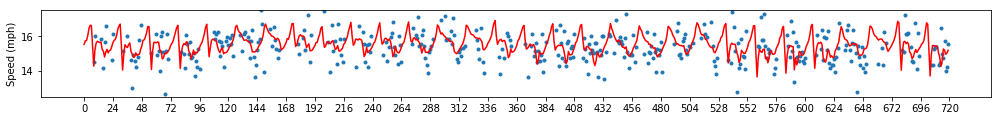

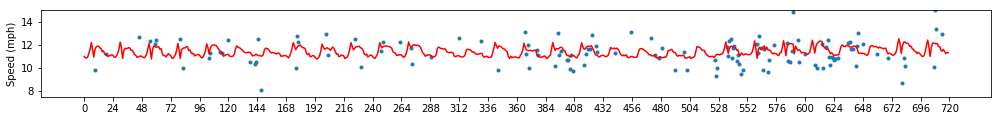

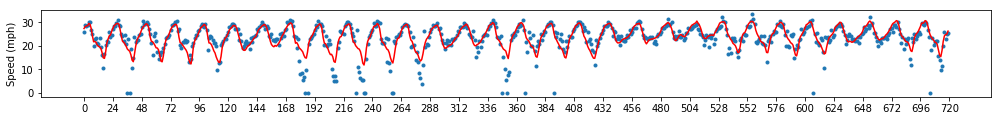

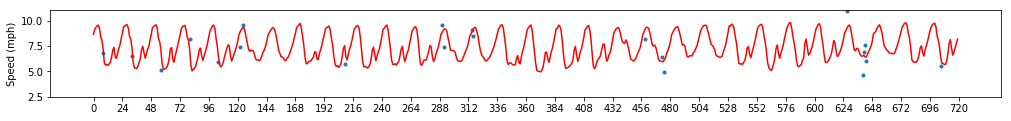

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

for loc in [0, 1, 2, 3]:
    fig = plt.figure(figsize = (15, 1.5))
    ax = fig.add_axes([0.10, 0.18, 0.88, 0.80])
    plt.plot(dense_mat[loc, :], '.', linewidth = 1)
#     plt.plot((dense_mat.sum(0)/(mat != 0).sum(0)), '-', color = 'black', linewidth = 0.8)
    plt.plot(mat[loc, :], color = 'red')
    plt.xticks(np.arange(0, 24 * 30 + 1, 24))
    plt.ylabel('Speed (mph)')
    if loc == 0:
        plt.ylim([12.5, 17.5])
    elif loc == 1:
        plt.ylim([7.5, 15])
    elif loc == 3:
        plt.ylim([2.5, 11])
    plt.show()
#     fig.savefig("../london_movement_speed{}.pdf".format(loc + 1))

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>